# Dogs vs. Cats Redux

## Kaggle Competition

In [1]:
%matplotlib inline
#path = 'data/dogscats/sample/'
path = 'data/dogscats/'

train_path = path + 'train/'
valid_path = path + 'valid/'
test_path = path + 'test/'
results_path = path + 'results/'
model_path = path + 'models/'

In [2]:
from utils import *
from vgg16 import Vgg16

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [3]:
batch_size = 64
num_epoch = 8

In [4]:
vgg = Vgg16()
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [5]:
vgg.finetune(batches)
vgg.model.optimizer.lr = 0.005
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [6]:
# vgg.fit(batches, val_batches, nb_epoch=num_epoch)
# vgg.model.save_weights(model_path+'finetune.h5')

In [7]:
vgg.model.load_weights(model_path+'finetune.h5')

In [8]:
batches, preds = vgg.test(test_path, batch_size=batch_size*2)
filenames = batches.filenames

isdog = preds[:,1]
isdog = isdog.clip(min=0.05, max=0.95)
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

Found 12500 images belonging to 1 classes.


In [9]:
subm = np.stack([ids, isdog], axis=1)

In [10]:
submission_file_name = results_path+'dogscats_sub1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

In [11]:
imgs = next(batches)

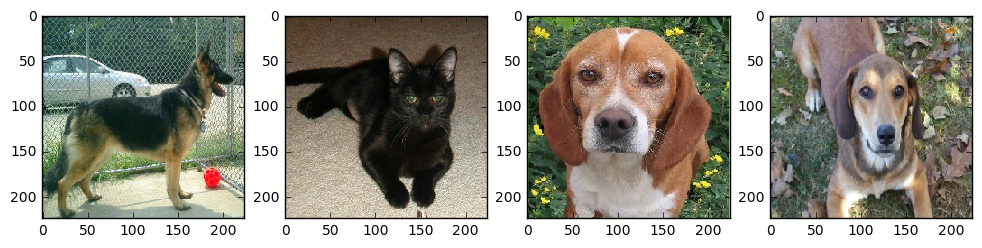

In [12]:
plots(imgs[:4])

In [13]:
print preds[:4]
print filenames[:4]

[[ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]]
['unknown/1.jpg', 'unknown/10.jpg', 'unknown/100.jpg', 'unknown/1000.jpg']


In [14]:
batches, preds = vgg.test(valid_path, batch_size=batch_size*2)

Found 2000 images belonging to 2 classes.


In [15]:
filenames = batches.filenames
expected_labels = batches.classes

my_preds = preds[:,0]
my_labels = np.round(1-my_preds)

In [16]:
from keras.preprocessing import image

def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
n_view = 4

Found 1972 correct lables


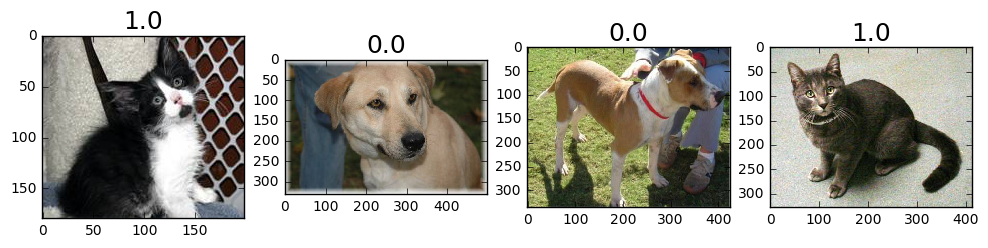

In [17]:
correct = np.where(my_labels == expected_labels)[0]
print "Found %d correct lables" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, my_preds[idx])

Found 28 incorrect lables


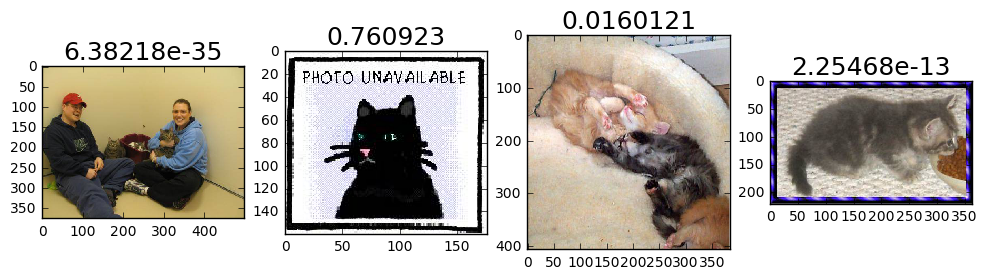

In [18]:
incorrect = np.where(my_labels != expected_labels)[0]
print "Found %d incorrect lables" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, my_preds[idx])

Found 1000 correct cats labels


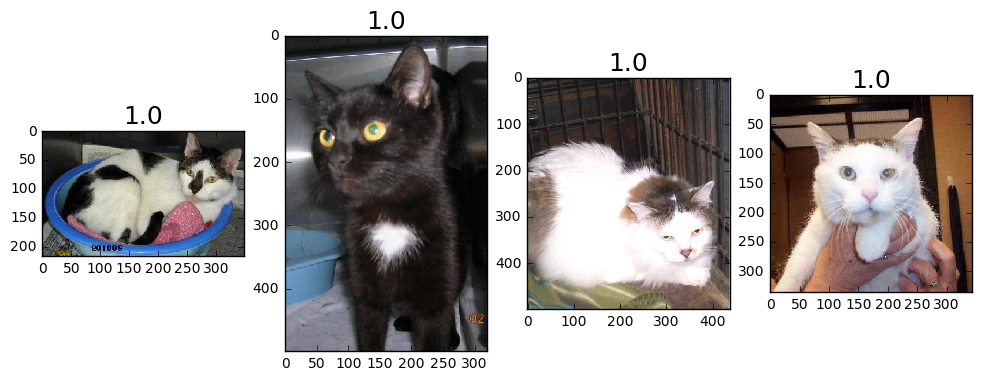

In [19]:
correct_cats = np.where((my_labels==0) & (my_labels==expected_labels))[0]
print "Found %d correct cats labels" % len(correct_cats)
most_correct_cats = np.argsort(my_preds[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], my_preds[correct_cats][most_correct_cats])

Found 972 correct dogs labels


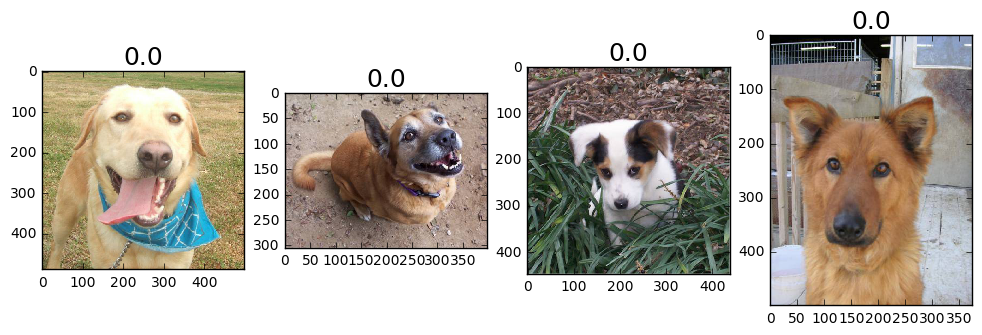

In [20]:
correct_dogs = np.where((my_labels==1) & (my_labels==expected_labels))[0]
print "Found %d correct dogs labels" % len(correct_dogs)
most_correct_dogs = np.argsort(my_preds[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], my_preds[correct_dogs][most_correct_dogs])

Found 8 incorrect cats


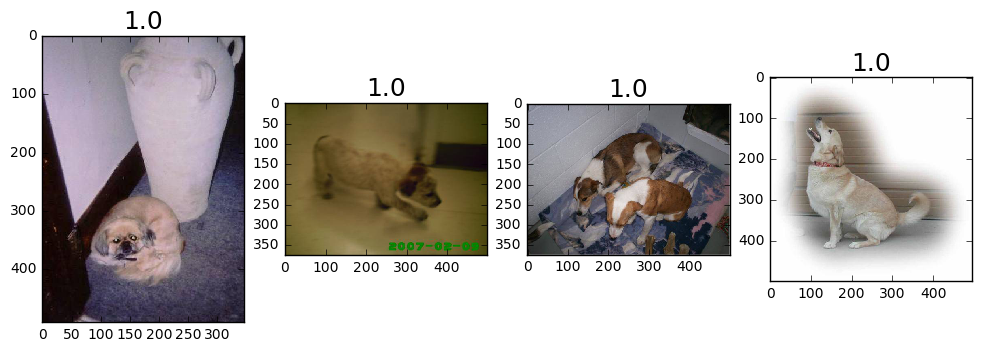

In [21]:
incorrect_cats = np.where((my_labels==0) & (my_labels!=expected_labels))[0]
print "Found %d incorrect cats" % len(incorrect_cats)
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(my_preds[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], my_preds[incorrect_cats][most_incorrect_cats])

Found 20 incorrect dogs


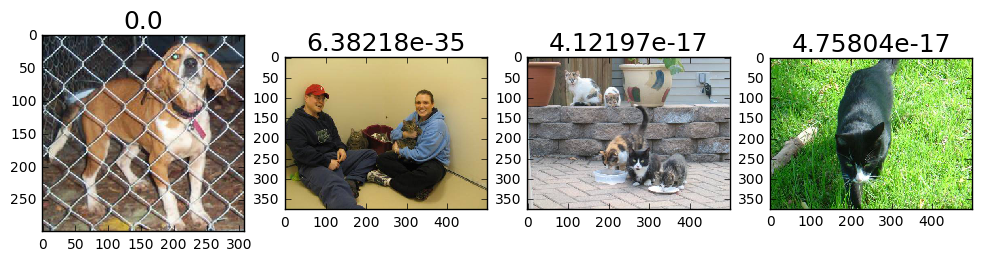

In [22]:
incorrect_dogs = np.where((my_labels==1) & (my_labels!=expected_labels))[0]
print "Found %d incorrect dogs" % len(incorrect_dogs)
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(my_preds[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], my_preds[incorrect_dogs][most_incorrect_dogs])

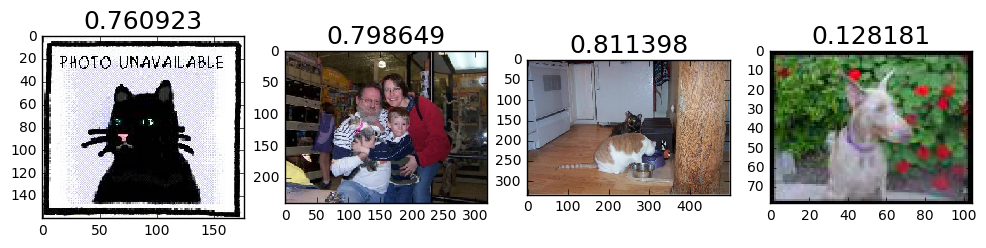

In [23]:
most_uncertain = np.argsort(np.abs(my_preds-0.5))
plots_idx(most_uncertain[:n_view], my_preds[most_uncertain])

[[1000   20]
 [   8  972]]


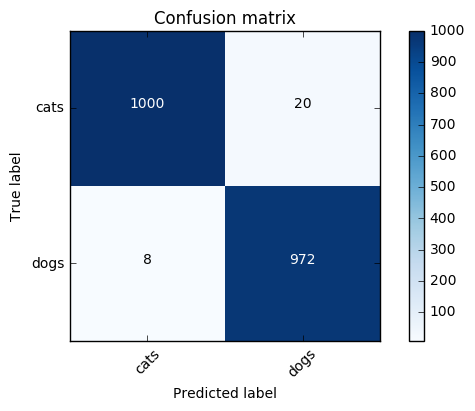

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, my_labels)
plot_confusion_matrix(cm, batches.class_indices)

## Dropout & Data Augmentation

There doesn't seem to be overfitting going on yet. Start by removing dropout to observe overfitting, then correct with data augmentation.

TODO:

1. Remove dropout and retrain until overfitting occurs
2. Add data augmentation and train (hopefully longer) until overfitting occurs
3. Add dropout, and train (even longer) until overfitting occurs
4. Add batchnorm?

### Remove Dropout

In [25]:
model = vgg_ft(2)
model.load_weights(model_path+'finetune.h5')

In [26]:
layers = model.layers

# get all conv layers
last_conv_idx = [index for index,layer in enumerate(layers)
                        if type(layer) == Convolution2D][-1]
conv_layers = layers[:last_conv_idx+1]
fc_layers = layers[last_conv_idx+1:]

# create model on just conv layers
conv_model = Sequential(conv_layers)

In [27]:
# batches = get_batches(path+'train', shuffle=False, batch_size=batch_size)
# val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size)

# val_classes = val_batches.classes
# train_classes = batches.classes
# val_labels = onehot(val_classes)
# train_labels = onehot(train_classes)

# save_array(model_path + 'train_convlayer_labels.h5', train_labels)
# save_array(model_path + 'valid_convlayer_labels.h5', val_labels)

In [28]:
# train_features = conv_model.predict_generator(batches, batches.nb_sample)
# val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)

# save_array(model_path + 'train_convlayer_features.h5', train_features)
# save_array(model_path + 'valid_convlayer_features.h5', val_features)

In [29]:
train_features = load_array(model_path + 'train_convlayer_features.h5')
val_features = load_array(model_path + 'valid_convlayer_features.h5')
train_labels = load_array(model_path + 'train_convlayer_labels.h5')
val_labels = load_array(model_path + 'valid_convlayer_labels.h5')

In [30]:
train_features.shape

(23000, 512, 14, 14)

In [31]:
# Copy the weights from the pre-trained model.
# NB: Since we're removing dropout, we want to half the weights
def proc_wgts(layer): return [o/2 for o in layer.get_weights()]

In [32]:
def fc_model(p):
    model = Sequential([
            MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
            Flatten(),
            Dense(4096, activation='relu'),
            Dropout(p),
            Dense(4096, activation='relu'),
            Dropout(p),
            Dense(2, activation='softmax')
        ])
    
    for l1,l2 in zip(model.layers, fc_layers): l1.set_weights(proc_wgts(l2))
    
    model.compile(optimizer=RMSprop(lr=0.0000001, rho=0.7), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [33]:
no_drop = fc_model(0.0)
no_drop.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling2d_11 (MaxPooling2D)   (None, 512, 7, 7)     0           maxpooling2d_input_1[0][0]       
____________________________________________________________________________________________________
flatten_3 (Flatten)              (None, 25088)         0           maxpooling2d_11[0][0]            
____________________________________________________________________________________________________
dense_9 (Dense)                  (None, 4096)          102764544   flatten_3[0][0]                  
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, 4096)          0           dense_9[0][0]                    
___________________________________________________________________________________________

In [36]:
no_drop.fit(train_features, train_labels, nb_epoch=8, batch_size=batch_size,
             validation_data=(val_features, val_labels))
no_drop.save_weights(model_path+'vgg_no_dropout.h5')

Train on 23000 samples, validate on 2000 samples
Epoch 1/8
23000/23000 [==============================] - 33s - loss: 0.0441 - acc: 0.9930 - val_loss: 0.0678 - val_acc: 0.9860
Epoch 2/8
23000/23000 [==============================] - 33s - loss: 0.0418 - acc: 0.9933 - val_loss: 0.0686 - val_acc: 0.9855
Epoch 3/8
23000/23000 [==============================] - 33s - loss: 0.0396 - acc: 0.9936 - val_loss: 0.0677 - val_acc: 0.9860
Epoch 4/8
23000/23000 [==============================] - 33s - loss: 0.0375 - acc: 0.9940 - val_loss: 0.0663 - val_acc: 0.9865
Epoch 5/8
23000/23000 [==============================] - 33s - loss: 0.0358 - acc: 0.9944 - val_loss: 0.0685 - val_acc: 0.9865
Epoch 6/8
23000/23000 [==============================] - 33s - loss: 0.0340 - acc: 0.9947 - val_loss: 0.0671 - val_acc: 0.9865
Epoch 7/8
23000/23000 [==============================] - 33s - loss: 0.0324 - acc: 0.9950 - val_loss: 0.0679 - val_acc: 0.9865
Epoch 8/8
23000/23000 [==============================] - 33s -

In [35]:
no_drop.load_weights(model_path+'vgg_no_dropout.h5')

### Data Augmentation

### Final Model